In [1]:
from BenchmarkStrategy import *
from IStrategy import *
from BacktestEngine import *
from MarketUtils import *
from MarketData import *
from Configuration import *
from AnalyticsEngine import *
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize,minimize_scalar
from sympy import symbols, solve
import math
from mpmath import nsum, inf
import matplotlib.pyplot as plt
from scipy.optimize import brute
import matplotlib.dates as mdates
import datetime as dt


#number of days of history used to callibrate parameter
DAYS=30
#number of days before the need of re-callibration
SAFE=20

#How many standard deviation do we get in and out of a trade
IN=2
OUT=0

class StochasticOUStrategy(IStrategy):

    #parameters for dX=_miu(_theta-X)dt+_theta dW
    _beta=1
    _theta=0
    _miu=0
    _sigma=0
    #number of days remaining before re-callibration of parameters
    #including re-calculation of thresholds
    _remaining=0
    #thresholds: as, bs are short entry and exit; al, bl are long entry and exit
    _as=0
    _bs=0
    _al=0
    _bl=0
    _current_position=None
    _spreads=[]
    _mean_adjusted_spreads=[]
    _means_list=[]
    _betas_list=[]
    _vols_list=[]
    _day=0

    #?????maybe weight can be outside of strategy
    def __init__(self, data = [], state="inactive", weight = 1.0, capital=100):
        #?????I suppose theh data we are given only contains the two columns of the two indices we are trading
        super().__init__(data=data, state=state, weight=weight, capital=capital, name = "Stochastic--OU")
        self._data={}

    def generate_signal(self,element,index):
        self._day+=1
        idx = [asset for asset in element]
        #storing data
        if(len(self._data)==0):
            self._data[idx[0]]=[]
            self._data[idx[1]]=[]
        else:
            self._data[idx[0]].append(element[idx[0]])
            self._data[idx[1]].append(element[idx[1]])
        if(len(self._data[idx[0]])<DAYS+1):
            self._current_position={idx[0]: 0, idx[1]: 0}
            self._state="inactive"
            return {idx[0]: 0, idx[1]: 0}
        if(self._remaining==0):
            self.callibration(idx0=np.array(self._data[idx[0]][-(DAYS+1):-1]),idx1=np.array(self._data[idx[1]][-(DAYS+1):-1]))
            print("!!!!!!!!!!!!!!!!!!!!!self._beta   ",self._beta)
            self._remaining=SAFE
        self._remaining-=1

        #updating spread series
        print(self._day)
        self._spreads.append(element[idx[0]]-self._beta*element[idx[1]])
        self._mean_adjusted_spreads.append(element[idx[0]]-self._beta*element[idx[1]]-self._theta)
        #updating the array of means
        # print("{}   :{}".format(idx[0],element[idx[0]]))
        # print("{}   :{}".format(idx[1],element[idx[1]]))
        # print("self._theta:  ",self._theta)
        # print("exp(theta):  ",np.exp(self._theta))
        # print("self._beta:  ",self._beta)
        # print("self._miu:  ",self._miu)

        self._means_list.append(self._theta)
        #updating the array of betas
        self._betas_list.append(self._beta)
        self._vols_list.append(self._sigma)
        current_spread=element[idx[0]]-self._beta*element[idx[1]]

        if(self._current_position[idx[0]]>0 and element[idx[0]]-current_spread>=self._bl):
            self._current_position={idx[0]: 0, idx[1]: 0}
            self._state="inactive"
        if(self._current_position[idx[0]]<0 and current_spread<=self._bs):
            self._current_position={idx[0]: 0, idx[1]: 0}
            self._state="inactive"
        if(current_spread<=self._al):
            #?????this should depends on capital
            self._current_position[idx[0]]=1
            self._current_position[idx[1]]=-self._beta*1
            self._state="active"
        if(current_spread>=self._as):
            self._current_position[idx[0]]=-1
            self._current_position[idx[1]]=self._beta*1
            self._state="active"
        print(index+"   "+str(current_spread))
        print("mean    ",self._theta)
        print(self._current_position)
        return self._current_position.copy()

            

    def callibration(self,idx0,idx1):
        dt=1
        # idx0=np.log(idx0)
        # idx1=np.log(idx1)
        n=len(idx0)
        def given_beta(b):
            xab=np.array([idx0[i]-idx1[i]*b for i in range(0,len(idx0))])
            # print(xab)
            xx=sum(xab[:-1])
            xy=sum(xab[1:])
            xxx=sum((xab**2)[:-1])
            xxy=np.dot(xab[:-1],xab[1:])
            xyy=np.dot(xab[1:],xab[1:])
            theta=(xy*xxx-xx*xxy)/(n*(xxx-xxy)-(xx**2-xx*xy))
            # print("@@@@@@@@@@@@@@@@@@@@@@ theta   ",theta)

            miu=-(1/dt)*np.log((xxy-theta*xx-theta*xy+n*(theta)**2)/(xxx-2*theta*xx+n*(theta)**2))


            sigma=np.sqrt(((2*miu)/(n*(1-np.exp(-2*miu*dt))))*(xyy-2*np.exp(-miu*(dt))*xxy+np.exp(-2*miu*dt)*xxx
            -2*theta*(1-np.exp(-miu*dt))*(xy-np.exp(-miu*dt)*xx)+n*(theta)**2*(1-np.exp(-miu*dt))**2))
            # print("@@@@@@@@@@@@@@@@@@@@@@ sigma   ",sigma)


            return theta, miu, sigma
 
        def l(b):
            #repeat
            xab=np.array([idx0[i]-idx1[i]*b for i in range(0,len(idx0))])

            theta, miu, sigma = given_beta(b)
            return miu
        
        def neg_l(b):
            b=b[0]
            # print("                      b  ",-l(b))
            return -l(b)

        bounds_of_beta=(np.mean(idx0)/np.mean(idx1)-1,np.mean(idx0)/np.mean(idx1)+1)
        print(bounds_of_beta)
        # self._beta = minimize_scalar(neg_l,bounds=(-2, 2)).x
        self._beta=brute(neg_l,(bounds_of_beta,), finish=None)   
        self._theta, self._miu, self._sigma = given_beta(self._beta)


        actual_mean=np.mean(idx0-self._beta*idx1)
        if((idx0-self._beta*idx1>self._miu).all() or (idx0-self._beta*idx1<self._miu).all()):
            self._theta=actual_mean
            print("HERERERERERERERERERERRRERE")
            print("self._miu  ",self._miu)
            print("self._beta  ",self._beta)

        print("day ",self._day)
        print(self._theta, self._miu, self._sigma)


        self._al=-IN*self._sigma+self._theta
        self._bl=OUT*self._sigma+self._theta
        self._as=IN*self._sigma+self._theta
        self._bs=-OUT*self._sigma+self._theta
        # #??????same as linear regression OLS?
        # reg = LinearRegression(fit_intercept=False).fit(idx1.reshape(-1, 1), idx0)
        # print("!!!!!!!!!!!!!!!!!!!OLS Beta ",reg.coef_)
        # print("                      OLS  ",-l(reg.coef_[0]))

        # #updating boundaries
        # a = symbols('a')
        # #define equation
        # def equation(a):
        #     def summand_1(n):
        #         product1=((np.sqrt(2)*a)**(2*int(n)+1))/math.factorial(2*int(n)+1)
        #         product2=math.gamma((2*n+1)/2)
        #         return product1*product2
        #     sum1=sum([summand_1(i) for i in range(0,10)])
        #     def summand_2(n):
        #         product1=((np.sqrt(2)*a)**(2*int(n)))/math.factorial(2*int(n))
        #         product2=math.gamma((2*n+1)/2)
        #         return product1*product2
        #     sum2=sum([summand_2(i) for i in range(0,10)])
        #     return 0.5*(sum1)-a*(np.sqrt(2)/2)*sum2
        # #solve the equation
        # expr = equation(a)
        # sol = solve(expr)
        # a_d = sol[0]
        # b_d = -a_d
        # def d_(k_d):
        #     return k_d*self._sigma/(np.sqrt(2*self._miu))+self._theta
        # self._as=d_(a_d)
        # self._bs=d_(b_d)
        # self._al=d_(-a_d)
        # self._bl=d_(-b_d)
        # print(self._as,self._bs,self._al,self._bl)
        # #calculating the boundaries

    def get_spreads(self) -> pd.DataFrame:
        '''
        return mean adjusted spread
        '''
        return pd.DataFrame({"mean-adjusted spreads":self._mean_adjusted_spreads,"original-spreads":self._spreads})

    def get_means_list(self):
        '''
        return the means of the OU process modeled spreads
        '''
        return pd.DataFrame({"means":self._means_list})

    def get_betas_list(self):
        '''
        return the betas of the OU process modeled spreads
        '''
        return pd.DataFrame({"betas":self._betas_list})   

    def get_vols_list(self):
        '''
        return the vols of the OU process modeled spreads
        '''
        return pd.DataFrame({"vols":self._vols_list})   

    def stop_loss():
        #TODO
        pass




/usr/local/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:

# test = StochasticOUStrategy()
# test.callibration(np.array([220,190,220,190,220,190]),np.array([110,101,100,100,100,110]))
# print(test._beta)

price_data = get_data(type='index', col_list=['^IXIC','^GSPC'], termDates=['2021-02-10','2022-05-30'])
strategy = StochasticOUStrategy()

assets = list(price_data.copy())
capital=1
# setting up trade dataframe
trades = pd.DataFrame(index=price_data.index.copy())
curr_price={}
prev_position={}
for asset in assets:
    prev_position[asset]=0
for index,row in price_data.iterrows():
    prev_price=curr_price.copy()
    # constructing current price dict
    delta_price={}
    daily_gain=0
    investment=0
    for asset in assets:
        curr_price[asset] = row[asset]
        delta_price[asset]=0
        if(prev_price):
            delta_price[asset]=curr_price[asset]-prev_price[asset]
            investment+=abs(prev_position[asset])*prev_price[asset]
        daily_gain+=prev_position[asset]*delta_price[asset]
        if(investment==0):
            daily_return=0
        else:
            daily_return=daily_gain/investment
    
        
    # updates trade object with final positions
    trades.loc[index,"daily_return"]=daily_return
    capital=capital*(1+daily_return)
    trades.loc[index,"capital"]=capital

    prev_position=strategy.generate_signal(curr_price,index)
    for asset in prev_position:
        trades.loc[index,asset+"_Signal"] = prev_position[asset]


(2.431060549331198, 4.431060549331198)
day  32
-94.28511640867134 0.11793789589527164 124.9830019533471
!!!!!!!!!!!!!!!!!!!!!self._beta    3.3784289703838293
32
2021-03-26   -288.9707431692259
mean     -94.28511640867134
{'^IXIC': 0, '^GSPC': 0}
33
2021-03-29   -356.3954063087549
mean     -94.28511640867134
{'^IXIC': 1, '^GSPC': -3.3784289703838293}
34
2021-03-30   -328.29051723775956
mean     -94.28511640867134
{'^IXIC': 0, '^GSPC': 0}
35
2021-03-31   -175.25619204353643
mean     -94.28511640867134
{'^IXIC': 0, '^GSPC': 0}
36
2021-04-01   -100.73530952398869
mean     -94.28511640867134
{'^IXIC': 0, '^GSPC': 0}
37
2021-04-05   -71.33914193568671
mean     -94.28511640867134
{'^IXIC': 0, '^GSPC': 0}
38
2021-04-06   -65.1368388381743
mean     -94.28511640867134
{'^IXIC': 0, '^GSPC': 0}
39
2021-04-07   -94.98126900515308
mean     -94.28511640867134
{'^IXIC': 0, '^GSPC': 0}
40
2021-04-08   -12.687990335251015
mean     -94.28511640867134
{'^IXIC': 0, '^GSPC': 0}
41
2021-04-09   -48.666443383

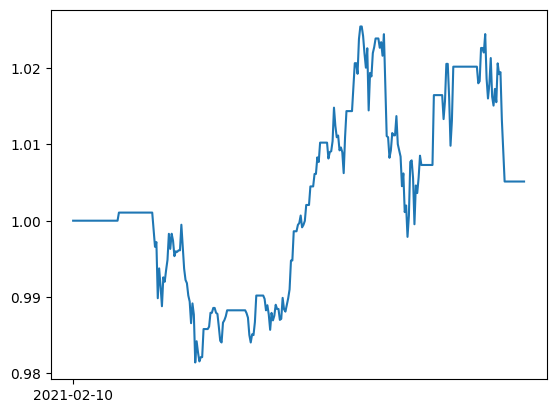

In [5]:
trades["mean-adjusted spreads"] = [np.nan]*(DAYS+1)+strategy.get_spreads()["mean-adjusted spreads"].tolist()
trades["original-spreads"] = [np.nan]*(DAYS+1)+strategy.get_spreads()["original-spreads"].tolist()
trades["mean"] = [np.nan]*(DAYS+1)+strategy.get_means_list()["means"].tolist()
trades["vols"] = [np.nan]*(DAYS+1)+strategy.get_vols_list()["vols"].tolist()
trades["betas"] = [np.nan]*(DAYS+1)+strategy.get_betas_list()["betas"].tolist()

# backtest = backtest_walk_forward(price_data)
# backtest.add_strategy(strategy)
# trades = backtest.run_backtest()
# spread= strategy.get_spreads()
# spread_and_params=pd.concat([spread,strategy.get_means_list(),strategy.get_betas_list()], axis=1)
pd.set_option('display.max_rows', None)
# print(spread_and_params)
# plt.plot(spread_and_params["mean-adjusted spreads"])
# plt.plot(3*strategy.get_vols_list())
# plt.plot(-3*strategy.get_vols_list())
# plt.plot([0]*len(strategy.get_vols_list()))
# plt.show()
trades.to_csv("OUTPUT.csv")
pd.to_datetime(trades.index)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.plot(trades.index,trades["capital"])
plt.show()

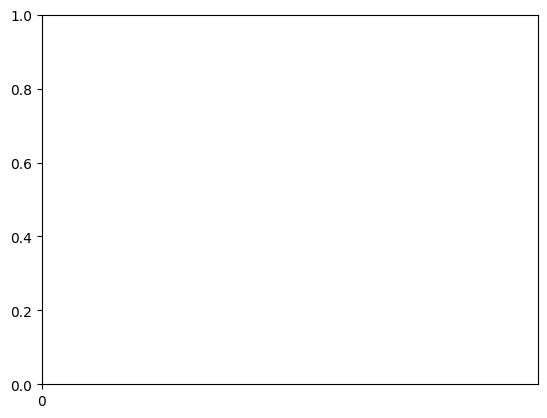

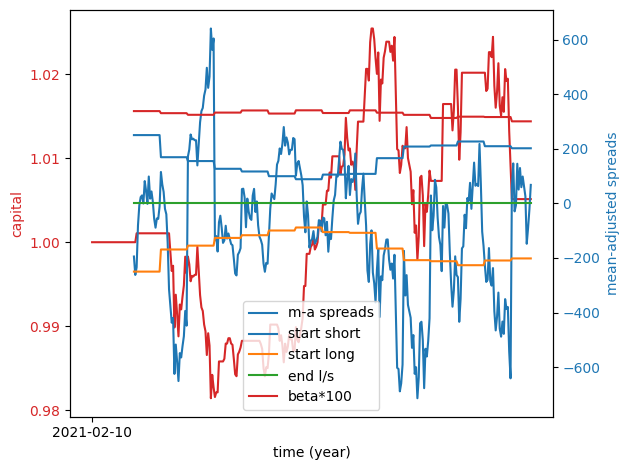

In [6]:
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

t = np.arange(0.01, 10.0, 0.01)
data1 = np.exp(t)
data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (year)')
ax1.set_ylabel('capital', color=color)
ax1.plot(trades.index,trades["capital"],color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_major_locator(mdates.YearLocator())

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('mean-adjusted spreads', color=color)  # we already handled the x-label with ax1

ax2.plot(trades.index,trades["mean-adjusted spreads"], label="m-a spreads",color=color)

ax2.plot(trades.index,trades["vols"].mul(IN), label="start short")
ax2.plot(trades.index,trades["vols"].mul(-IN),label="start long")
ax2.plot(trades.index,trades["vols"].mul(0), label="end l/s")
ax2.plot(trades.index,trades["betas"].mul(100), label="beta*100")

ax2.tick_params(axis='y', labelcolor=color)
ax2.xaxis.set_major_locator(mdates.YearLocator())
plt.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()